## Цель работы 

Получить практические навыки работы по решению задачи первичного анализа «сырых» данных, подготовки массива к обработке, выявления и описания зависимостей в исходных данных с использованием языка программирования.

# Первичный анализ исходных данных

## Описание набора данных

Набор данных "Combined Cycle Power Plant Data Set" содержит 9568 записей об электростанции комбинированного цикла за 6 лет (с 2006 по 2011 года), когда она работала на полную мощность. Каждая запись состоит из следующих среднечасовых показателей окружающей среды:
  1. Температуры (AT) в диапазоне от 1.81°C до 37.11°C;
  2. Атмосферного давления (AP) в диапазоне от 992.89 до 1033.30 миллибар;
  3. Относительной влажности (RH) в диапазоне от 25.56% до 100.16%;
  4. Разрежение выхлопных газов (V) в диапазоне от 25.36 до 81.56 сантиметров ртутного столба;
  5. Выработки электроэнергии (PE) в диапазоне от 420.26 до 495.76 МВт;

Средние показатели работы электростанции вычислялись исходя из множества показателей датчиков, расположенных около электростанции, которые записывали эти показатели ежесекундно. Переменные даны без нормализации.

В электростанции комбинированного типа используются газотурбинные установки, паровые турбины и тепловые генераторы пара с рекуперацией тепла. В электростанции комбинированного типа электричество генерируется с помощью газотурбин и паротурбин, которые работают в одном цикле и передаются от одной турбины к другой. В то время, как выхлопные газы извлекаются из паровой турбины и воздействуют на неё, три другие переменные окружающей среды оказывают влияние на работу газотурбинной установки.
Для совместимости с нашими основными исследованиями и для того, чтобы можно было проводить статические тесты 5x2, мы предоставили данные перемешанные пять раз. Для каждой перетасовки проводится двухкратный анализ, и полученные 10 измерений используются для статистического тестирования.

## Подключение необходимых библиотек

Перед началом работы установим необходимые для работы модули и библиотеки:
- pip install numpy pandas sklearn seaborn matplotlib
- pip install jupyterlab

Назначение библиотек:
* numpy - обработка многомерных массивов, линейная алгебра, преобразование Фурье, случайные числа
* pandas - обработка (загрузка, сохранение, анализа) данных 
* seaborn - визуализация данных (на базе matplotlib)
* sklearn - (классификация, регрессия, кластеризация...)
* scipy - пакет для выполнения научных и инженерных расчётов.

In [1]:
# Python 3.8.10
import pandas as pd
import numpy  as np
import sklearn as sk

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

## Загрузка входных данных

Для загрузки табличных данных из файла применим функцию .read_csv() из библиотеки Pandas с указанием параметров (путь, кодировка файла, разделитель в данных, обработка колонок с заголовками или датой...)

In [2]:
df = pd.read_csv('ccpp_nan.csv', # путь к файлу
    sep=';',    # разделитель данных в файле
    header=0,   # считываем заголовки из первой строки
    na_values =  ['???', ' '], # доп. символы для обозначения отсутствующих значений
    decimal=',' # символ-разделитель дробной и целой частей чисел
)

df[:2] # отображаем первые две строки таблицы df

AT      V       AP     RH      PE
0   8.34  40.77  1010.84  90.01  480.48
1  23.64  58.49  1011.40  74.20  445.75

Переменная __df__ в данном случае является экземпляром класса __DataFrame__ библиотеки __pandas__.

Осмотрим полученную таблицу и убедимся, что данные загружены корректно

In [3]:
df [0:3] # Трёхстрочный срез исходной таблицы DataFrame

AT      V       AP     RH      PE
0   8.34  40.77  1010.84  90.01  480.48
1  23.64  58.49  1011.40  74.20  445.75
2  29.74  56.90  1007.15  41.91  438.76

## Осмотр данных / Первичный анализ

### Размер таблицы

Свойство __DataFrame.shape__ возвращает два значения соответствующей таблице - [кол-во строк, кол-во столбов]

In [4]:
nrow = df.shape[0] # Кол-во строк
ncol = df.shape[1] # Кол-во столбцов
print("Итого: " + str(nrow) + " строк и " + str(ncol) + " столбцов(признаков).")

Итого: 9568 строк и 5 столбцов(признаков).


### Признаки

Метод __describe()__ выводит основные статистически  данных по каждому числовому признаку (типы int64 и float64): 
* count - число непропущенных значений;
* mean - среднее арифметическое;
* std - стандартное отклонение (среднеквадратическое);
* min, max - минимальное и максимальное значение;
* 0.25, 0.50, 0.75 квартили;
* unique - кол-во уникальных значения;
* top - самое часто встречающееся значение (мода);
* freq - кол-во значений 'top';


In [5]:
df.describe() # описание для числовых значений

AT            V           AP           RH           PE
count  9549.000000  9551.000000  9548.000000  9550.000000  9542.000000
mean     19.645846    54.311696  1013.259102    73.311018   454.370969
std       7.452793    12.712146     5.937384    14.602259    17.071815
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.107500    63.322500   439.750000
50%      20.340000    52.080000  1012.940000    74.980000   451.585000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000

### Названия признаков

Получим список всех столбцов, при помощи свойства __DataFrame.columns__

In [6]:
df.columns

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

Из описание исходной задачи, данные признаки имеют следующий смысл:
  1. AT - температура окружающей среды в диапазоне от 1.81°C до 37.11°C;
  2. AP - атмосферное давление среды в диапазоне от 992.89 до 1033.30 миллибар;
  3. RH - относительная влажность среды в диапазоне от 25.56% до 100.16%;
  4. V - разрежение выхлопных газов в диапазоне от 25.36 до 81.56 сантиметров ртутного столба;
  5. PE - почасовая выработка электроэнергии в диапазоне от 420.26 до 495.76 МВт;

## Пропущенные значения

Выберем из таблицы набора данных те строки, в которых отсутствует значение в
хотя бы одном из столбцов:

In [7]:
df[df.isna().any(axis=1)]

AT      V       AP     RH      PE
33    30.98  67.45  1015.18  45.40     NaN
209    9.86  38.38  1018.22  85.35     NaN
214   25.63  58.86  1014.86    NaN  443.84
335   26.63  61.47  1008.18  69.00     NaN
451   17.48    NaN  1021.51  84.53  460.01
...     ...    ...      ...    ...     ...
9049  11.93    NaN  1013.15  96.08  474.57
9070    NaN  39.85  1012.78  88.09  481.53
9382  18.28    NaN  1018.83  52.88  458.59
9471  32.33  69.89  1014.18    NaN  427.29
9562  13.79  42.07  1018.27    NaN  462.25

[100 rows x 5 columns]

Кроме самих строк (первых и последних 5 строк в отфильтрованной выборке),  
также было выведено их количество - таких строк оказалось 100.

Также выведем количество пропущенных значений для каждого из столбцов: 

In [8]:
df.isna().sum() 

AT    19
V     17
AP    20
RH    18
PE    26
dtype: int64

Для понимания того, как распределены отсутствующие значения в исходной таблице, построим графическое изображение __таблицы-маски__

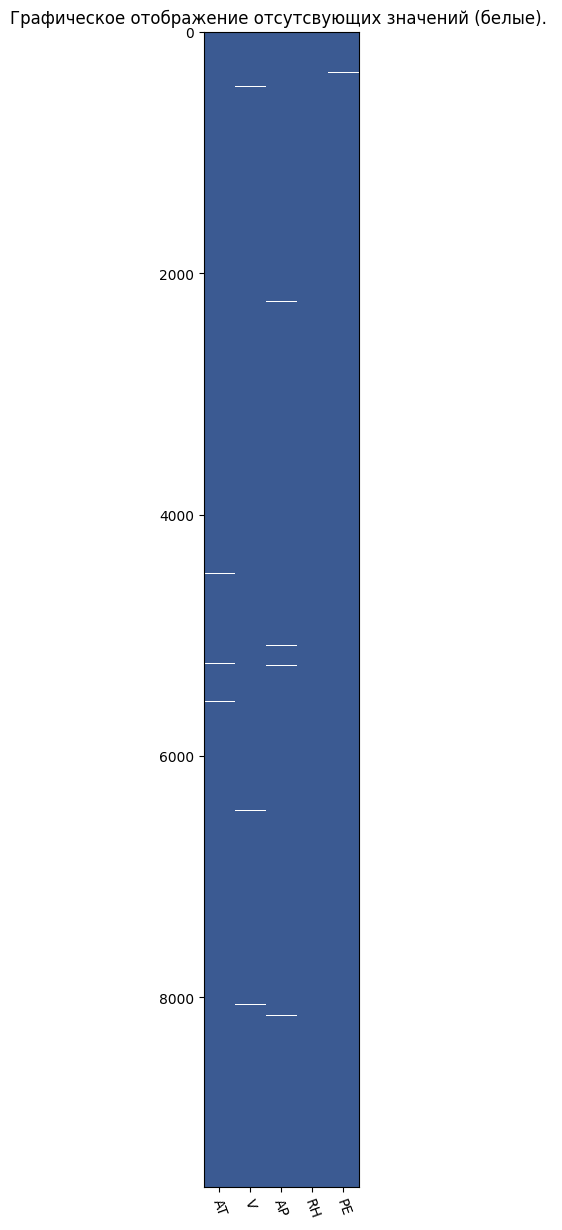

In [9]:
from matplotlib.colors import ListedColormap
def plotTableNA(dataF, addToTilte =""):
    '''  Функция для построения графика отображение отсутсвующих значений'''
    
    if   len(dataF.columns)> 20:   K = 3
    elif len(dataF.columns)== 1:   K = 1
    else:                          K = 1.7 
        
    figSizeH = 15        # размер полотна, высота
    figSizeW = int(len(dataF.columns)/K) # размер полотна, ширина
    fig, ax = plt.subplots(figsize=(figSizeW, figSizeH))

    # Отрисовать матрицу значений функцией imshow. Применяется цветовая палитра 
    plt.imshow(
        dataF.isna(),
        cmap = ListedColormap(['#3B5A92', 'white',]), #cm.get_cmap('jet'),
        aspect='auto',  # ‘auto’ | ‘equal’ | scalar]
        interpolation= 'none'
    )
    ax.set_xticks(np.arange(len(dataF.columns)))
    ax.set_xticklabels(dataF.columns, rotation=-70,)
    plt.title("Графическое отображение отсутсвующих значений (белые). "+ addToTilte)

# Вызов функции с указанием параметров
plotTableNA(df, "")

Перед дальнейшими действиями следует обработать пропущенные значения. Варианты обработки могут быть следующими:
- Вар.1. заполнить "особыми" значениями, которые невозможно встретить в выборке (прим.: "#NA")
- Вар.2. заполнить вычисленными значениями, рассчитанными на основе имеющихся значений признака (средние, мин., макс., и т.д.)
- Вар.3. исключить строки или столбцы:
  - Вар.3.1. исключить строки, в которых присутствуют пропущенные значения
  - Вар.3.2. исключить столбцы, в которых присутствуют пропущенные значения 

In [10]:
print("Размер исходного DataFrame", df.shape)
print("Вар.3.1. Размер при исключении по строкам", df.dropna(axis='index', how='any').shape)
print("Вар.3.2. Размер при исключении по столбцам", df.dropna(axis='columns', how='any').shape)
print()

percent = 100 - df.dropna(axis='index', how='any').shape[0] / df.shape[0] * 100
print("Процент строк с пропущенными значениями: ", percent, "%")

Размер исходного DataFrame (9568, 5)
Вар.3.1. Размер при исключении по строкам (9468, 5)
Вар.3.2. Размер при исключении по столбцам (9568, 0)

Процент строк с пропущенными значениями:  1.0451505016722393 %


Как можно заметить, в исходной выборки относительно небольшое число строк с пропущенными значениями, более конкретно - 100 строк, а это около 1% исходной выборки. Исключение по столбцам в нашем случае не подойдёт, поскольку будут исключены все столбцы. Процент исключения строк относительно небольшой и поэтому, чтобы не модифицировать исходную выборку искусственными значениями, выберем режим исключения __"Вар.3.1."__ 

In [11]:
# axis='index' - удаление строк
# axis='columns' - удаление столбцов
df = df.dropna(axis='index', how='any')
print("Размер таблицы после исключения пропусков", df.shape)

Размер таблицы после исключения пропусков (9468, 5)


Убедимся в том, ожидаемый результат совпадает с фактическим, т.н. в том, что в выборке отсутствуют строки с хотя бы одним пустым значением

In [12]:
df.isna().sum() 

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

## Приведение признаков к числовыми

На данном этапе в таблице все столбцы являются числовыми с типом float64.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9468 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9468 non-null   float64
 1   V       9468 non-null   float64
 2   AP      9468 non-null   float64
 3   RH      9468 non-null   float64
 4   PE      9468 non-null   float64
dtypes: float64(5)
memory usage: 443.8 KB


Поскольку все признаки в наборе данных, действительно, являются числовыми и вещественными, то дополнительные преобразования типов не требуются.

# Выбор целевого значения и признаков для анализа данных

## Корреляция

* __Коэффициент корреляции r-Пирсона__
  
  Мера линейной взаимосвязи переменных, при нелинейной взаимосвязи непоказателен. Не устойчив к выбросам в выборке. Учитывает числовые значения. Переменные должны иметь нормальное распределение. Изменяется в пределах от -1 до +1.

![Drag Racing](https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Correlation_examples.png/400px-Correlation_examples.png)

Построим матрицу корреляции между двумя различными переменными из исходной выборки. Коэффициенты корреляции будет считать по методу Пирсона.

In [14]:
corr_df = df.corr(method='pearson')
corr_df

AT         V        AP        RH        PE
AT  1.000000  0.843912 -0.507664 -0.541975 -0.948184
V   0.843912  1.000000 -0.413163 -0.310687 -0.869875
AP -0.507664 -0.413163  1.000000  0.100436  0.518308
RH -0.541975 -0.310687  0.100436  1.000000  0.389297
PE -0.948184 -0.869875  0.518308  0.389297  1.000000

Для того, чтобы визуально оценить величину коэффициентов корреляции постоим тепловую карту по значениям взаимозависимости признаков выборки.

/tmp/ipykernel_2960/1938546766.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_df, dtype=np.bool)


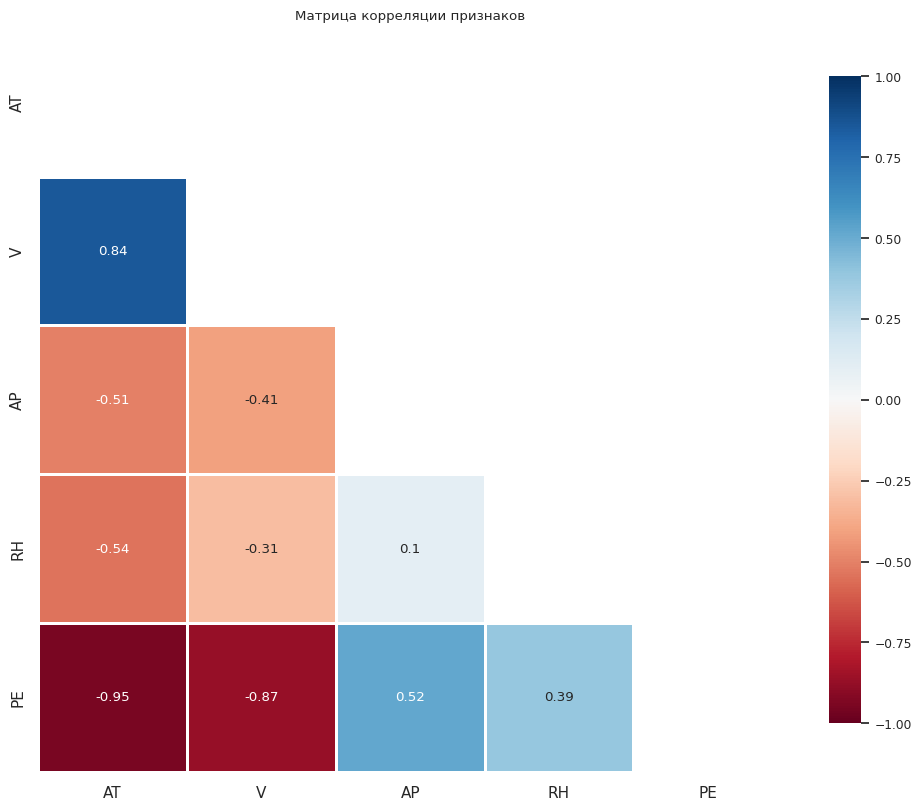

In [15]:
import matplotlib.pyplot as plt
sns.set(style="white") # цвет фона

# построить "маску" для отображения только половины корреляционной матрицы
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=0.8) # размер шрифта

# Построить тепловую карту
sns.heatmap(
    data=corr_df,   # объект-матрица корреляции 
    vmin=-1, vmax=1, center=0,
    annot=True, 
    cmap = 'RdBu',
    mask=mask,   # применить маску
    square=True, # форма ячейки - квадрат
    linewidths=1.0, # зазор между ячейки
    cbar_kws={"shrink": .7}  # уменьшить размер легенды
)
plt.title(u'Матрица корреляции признаков');


Как можно заметить из построенной тепловой карты, наиболее сильная корреляционная связь присутствует между температурой окружайщей среды (AT) и объёмом выработки электроэнергии (PE). Также сильная связь присутствует между разреженностью выхлопных паров (V) и объёмом выработки электроэнергии (PE), а также между температурой окружающей среды (AT) и разреженностью выхлопных паров (V). Первые две связи являются обратно-пропорциональными, поскольку коэффициент корреляции меньше 0. Последняя связь является прямо-пропорциональной, поскольку её коэффициент больше 0. Кроме того, данная связь вполне ожидаема, т.к. при большей температуре происходит большее выделение пара, и поэтому исследовательского интереса не представляет. Интерес представляют первые две выделенные корреляционные связи, поскольку они связаны с главным параметров электростанции - выходной мощностью. 

In [16]:
# Последовательное применение операции: 
# - получить единственный столбец, 
# - получить абсолютные значения, 
# - отсортировать
corr_df[['PE']].abs().sort_values(by="PE")

PE
RH  0.389297
AP  0.518308
V   0.869875
AT  0.948184
PE  1.000000

В качестве целевой переменной выберем признак:
- **'PE'** - объём вырабатываемой электроэнергии.

Данный признак был выбран в качестве целевого поскольку этот признак, по сути своей, является главным показателем работы электростанции.

В качестве независимых переменных выберем признаки с высоким абс. значением коэфф. корреляции, но при этом как можно более не связанные  между собой. Кандидаты: 
  * **'AT'** - Температура окружающей среды;
  * **'AP'**-  Атмосферное давление среды;
  * **'RH'** - Относительная влажность среды;
  * **'V'** - Разряженность выхлопных газов;
  
  

Составим список независимых переменных и целевой

In [17]:
features = ['AT', 'AP', 'RH', 'V']
target   = ['PE']

# Просмотр характеристик выбранных признаков

<Figure size 700x700 with 0 Axes>

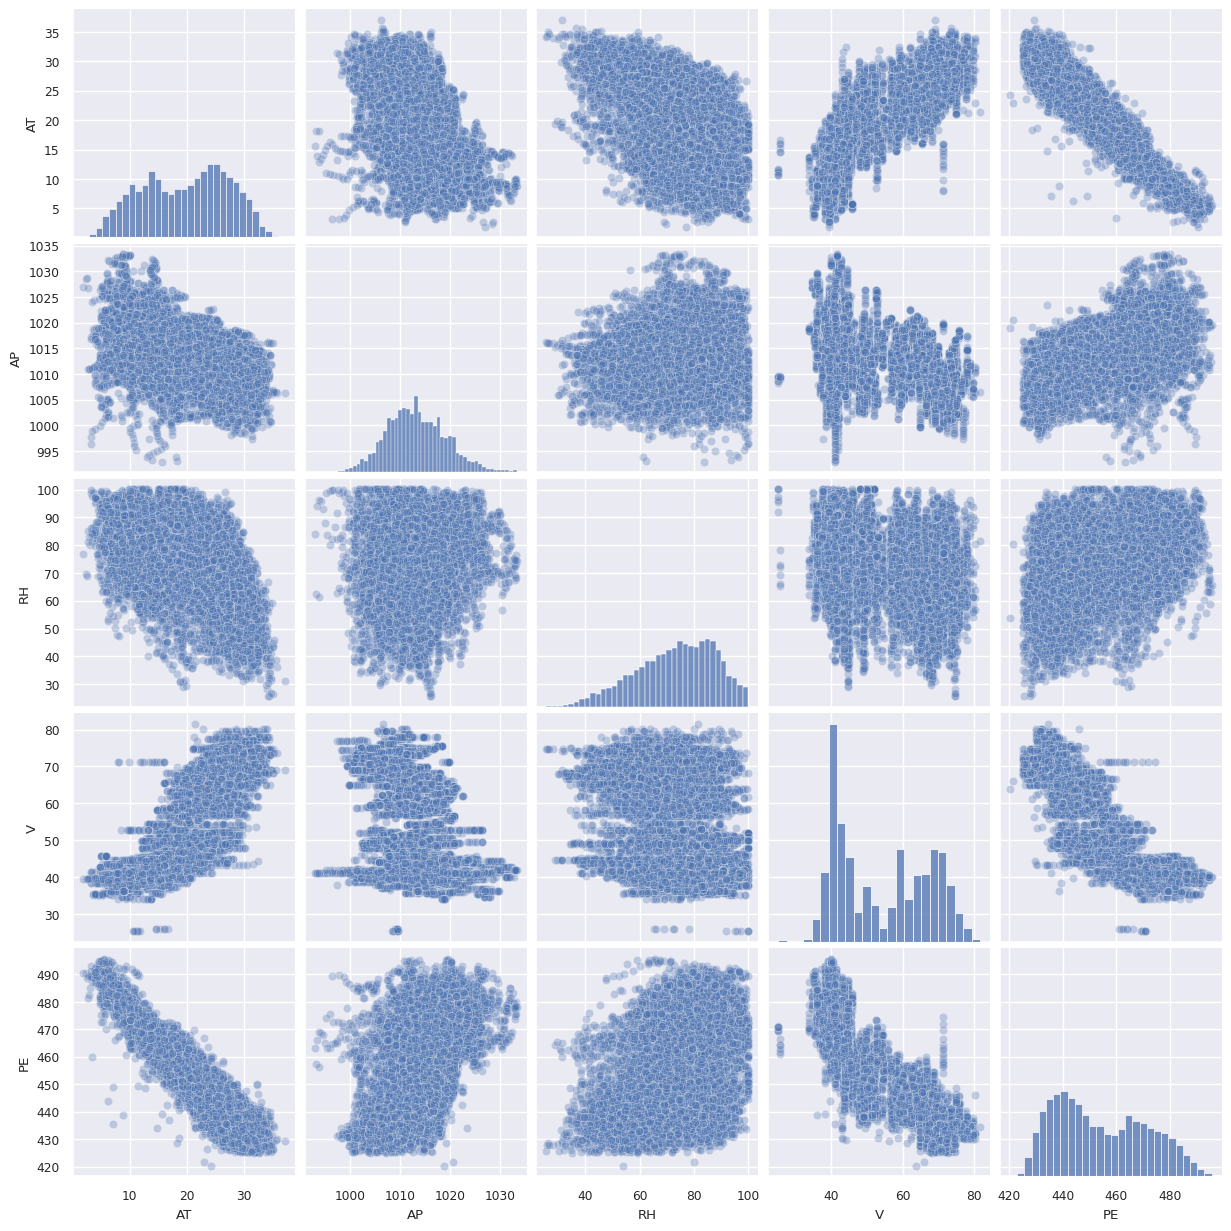

In [18]:
# График признаков попарно
plt.figure(figsize=(7,7))
%config InlineBackend.figure_format = 'png' # формат изображений PNG, для сокращения времени отрисовки графиков

sns.pairplot(
    df[features + target], 
    #hue = 'Type',         # Признак разделения
    kind="scatter",        # Тип даграмм: reg,scatter 
    diag_kind = 'hist',     # Тип диагоральных даграмм: hist, kde
    plot_kws={'alpha':0.3}  # прозрачность точек
); 

## Поиск и обработка выбросов

Судя по виду графиков рассеяния в "пустых областях" присутствуют небольшое число объектов, т.е. в выборе присутствуют аномально малые или большие значения - "выбросы". Для их обработки проведем следующие операции.

Сначала построим диаграммы размаха для независимых и целевой переменных и определим по ним границы разброса значений переменных.

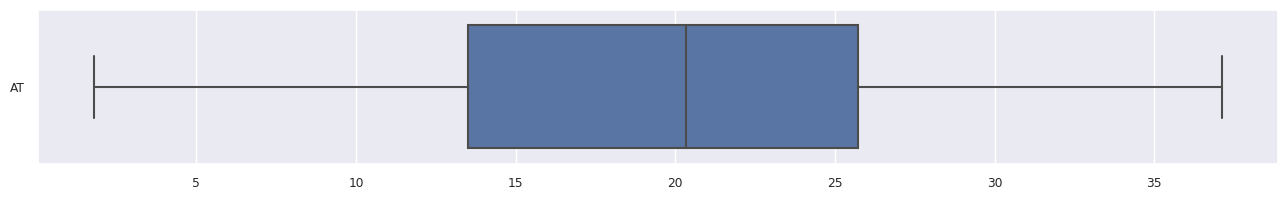

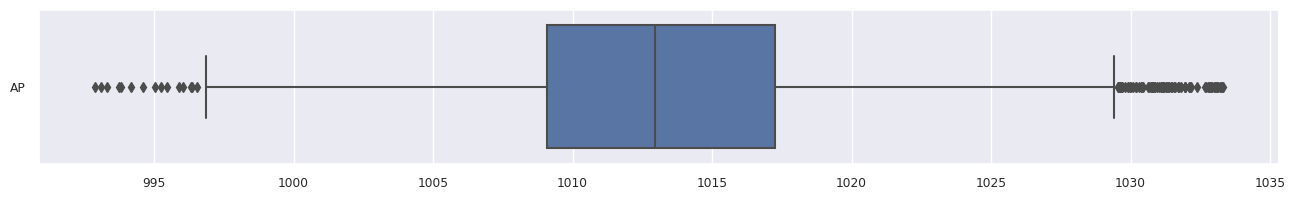

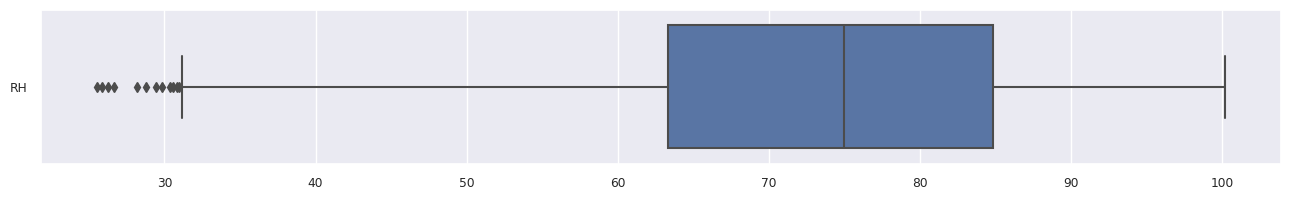

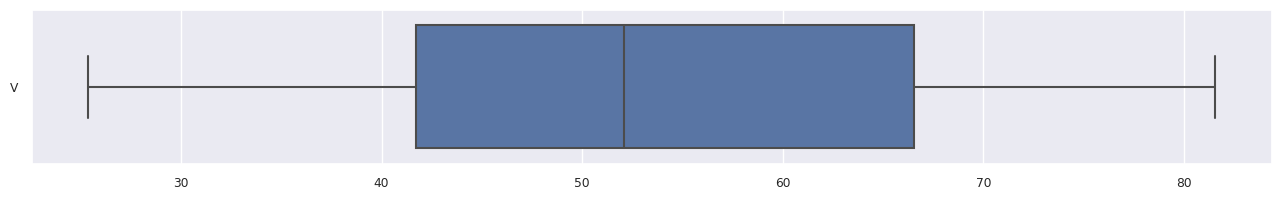

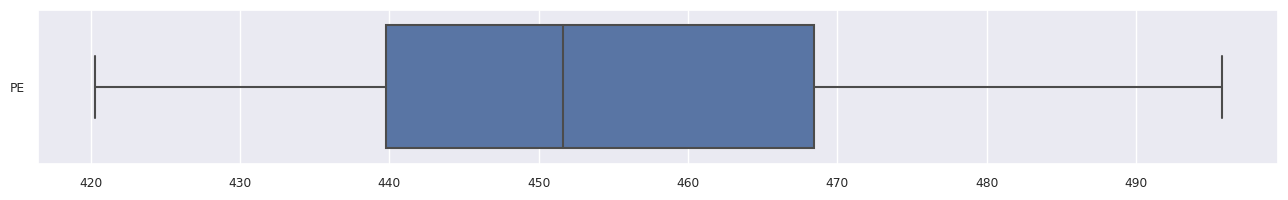

In [19]:
# Цикл: для каждого элемента в объединенном списке
for feature_name in (features+target):
    
    # Построить полотно для рисования с указанным размером
    plt.figure(figsize=(16,2))
    
    # На созданном полотне отрисовать boxplot
    sns.boxplot(
        data=df[[feature_name]], # данные
        orient='h' # ориентация графика
    )

Установим границы значений, для тех объектов таблицы, которые должны остаться

In [20]:
# создадим "словарь"/"хэш-таблицу" для удобного обращения, где ключ - это название признака
tressholdDict = { 
    'AT': (1.81, 38)        , # температура
    'AP': (996, 1029.5)     , # давление
    'RH': (30.5, 101)       , # относительная влажность
    'V' : (25, 82)          , # разряженность выхлопных газов
    'PE': (420, 495.5)      , # объём вырабатываемой электроэнергии
}

print(tressholdDict)

{'AT': (1.81, 38), 'AP': (996, 1029.5), 'RH': (30.5, 101), 'V': (25, 82), 'PE': (420, 495.5)}


Проверим, какая часть данных выходит за пределы границ значений


In [21]:
# Цикл: для каждого элемента в словаре/хэш-таблице пройтись по ключам - названиям признаков
for feature_name  in tressholdDict:
    threesMin =  tressholdDict[feature_name][0] # извлечь нижнее пороговое
    tresshMax =  tressholdDict[feature_name][1] # извлечь верхнее пороговое

    # Получить кол-во эл. вне пороговых значений. Прием - фильтрация
    over_count = len(df[ 
            # фильтр по двум границам. ~ инверсия логических значений:
            ~(df[feature_name] >= threesMin) & (df[feature_name] <= tresshMax)
        ] 
    )
    
    dcount = df[feature_name].count() # кол-во эл. общее
    
    print(
        '''{}. Принимаем пороговые значение равными {}.
        Кол-во эл. вне пороговых - {} из {} значение(ий) ({:.1%})\n'''.format( 
            
            feature_name, 
            tressholdDict[feature_name],
            over_count,
            dcount,
            over_count/ dcount,
        )
    )

AT. Принимаем пороговые значение равными (1.81, 38).
        Кол-во эл. вне пороговых - 0 из 9468 значение(ий) (0.0%)

AP. Принимаем пороговые значение равными (996, 1029.5).
        Кол-во эл. вне пороговых - 11 из 9468 значение(ий) (0.1%)

RH. Принимаем пороговые значение равными (30.5, 101).
        Кол-во эл. вне пороговых - 9 из 9468 значение(ий) (0.1%)

V. Принимаем пороговые значение равными (25, 82).
        Кол-во эл. вне пороговых - 0 из 9468 значение(ий) (0.0%)

PE. Принимаем пороговые значение равными (420, 495.5).
        Кол-во эл. вне пороговых - 0 из 9468 значение(ий) (0.0%)



Отфильтруем значения которые находятся вне пороговых.

In [22]:
# Во избежание путаницы создадим для полседующих операций копию исходного объетка
df_filtred = df.copy()

for feature_name in tressholdDict:
    threesMin =  tressholdDict[feature_name][0]
    tresshMax =  tressholdDict[feature_name][1]
    
    
    # фильтр по двум границам. Оператор "~" -инверсия логических значений
    df_filtred = df_filtred[ 
        (df_filtred[feature_name] >= threesMin ) & (df_filtred[feature_name] <= tresshMax) 
    ]
    print("Обработан ", feature_name )
    
    
print ("Отброшено {} строк. Осталось {} строк.".format(
    len(df)  - len(df_filtred),
    len(df_filtred))
)

Обработан  AT
Обработан  AP
Обработан  RH
Обработан  V
Обработан  PE
Отброшено 92 строк. Осталось 9376 строк.


AT 1.81 37.11
AP 996.03 1029.41
RH 30.59 100.16
V 25.36 81.56
PE 420.26 495.35


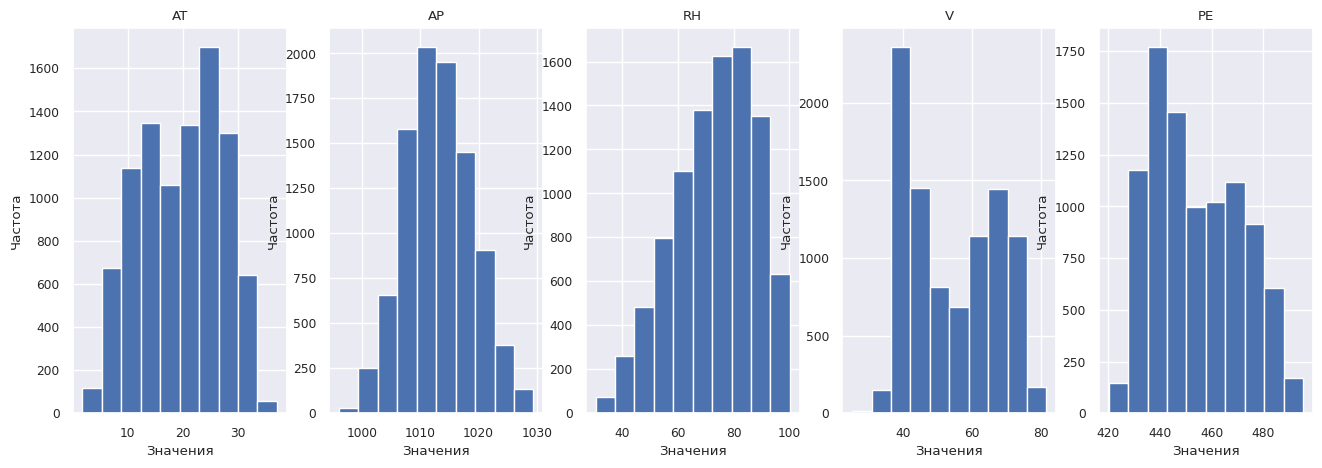

In [23]:
# Строим гистограммы по каждому признаку: 
# data[features].hist() #Упрощенный вывод графиков

plt.figure(figsize=(16, 5))
plot_number = 0

for feature_name in (features+target):
    plot_number += 1
    
    plt.subplot(1, len(features+target), plot_number)
    
    plt.hist(df_filtred[feature_name]) # Построение гистрограммы
    
    plt.title(feature_name)
    plt.xlabel(u'Значения')
    plt.ylabel(u'Частота')

    print(
        feature_name, 
        df_filtred[feature_name].min(),
        df_filtred[feature_name].max()
    )

## Сохранение данных

In [24]:
df_filtred.to_csv(
    'ccpp_nan_PREPARED.csv', # путь для сохранения
    sep = ';',
    index=False, # запрет сохранения "индексов" (тек. номеров строк)
)

## Формирование тренировочной и проверочной выборок

Для обучения и проверки качеста модели применяют прием заключающийся в разделении исходной выборки на части:
* Обучающую (Train) - данные, на которых модель формирует коэффициенты
* Проверочную (Test) - данные, которые предявляют обученой модели для получения и сравнения вычисленных(Predicted) значений. 

Для разделения воспользуемся функцией __train_test_split__ из пакета __sklearn__

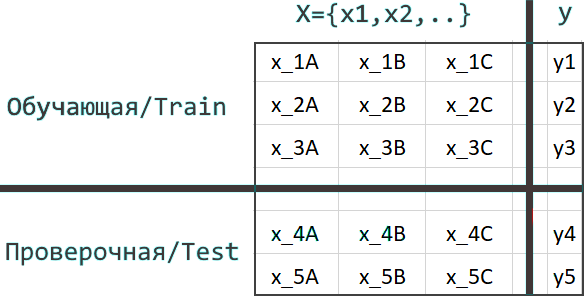

In [25]:
valid_size = 0.3 # доля тестовой части в выборке
rand_seed = 8 # начальное состояние генератора случ. чисел

x_train, x_test, y_train, y_test = train_test_split(
    df_filtred[features],   # исходные данные X
    df_filtred[target],     # исходные данные y
    
    test_size = valid_size, # доля тестовой части в выборке
    random_state=rand_seed, # начальное состояние генератора случ. чисел
    shuffle=True            # перемешивание
) 

In [26]:
print ("Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format(
    len(x_train), len(y_train),
    len(x_test),  len(x_test), 
    len(x_train) + len(x_test), len(y_train) + len(x_test),
))

Кол-во элементов: 
  x_train: 6563, y_train 6563 
  x_test:  2813, y_test  2813 
  total x: 9376, total y 9376 


Проверим содержимое обучающей и проверочной частей

In [27]:
x_test[:3] # Набор значений независимых переменных в тестовой выборке

AT       AP     RH      V
1467  32.39  1006.92  58.58  79.74
3762  16.07  1013.88  87.11  65.46
5042  16.63  1005.85  72.02  39.16

In [28]:
y_test[:3] # Набор значений целевой переменной в тестовой выборке

PE
1467  430.12
3762  450.54
5042  460.29

# Построение моделей

## Одномерная модель от признака 'AT'

Для получения линейной регрессионной модели созданим экземпляр класс 
__sklearn.linear_model.LinearRegression()__

In [29]:
lr = linear_model.LinearRegression()

Полученная модель требует процедуры обучения - подбора значений коэфф. для минимизации отличий между вычисленными значениями и предоставленными целевыми (обучающими y). У большинства моделей доступен метод __.fit( x_train,y_train)__

In [30]:
# Вычислить коэфф. Ki в функции y(x)=Ki*xi + .... + B
# на тренировочном наборе, т.е. обучить модель
lin_model_AT = lr.fit(
    x_train[['AT']], 
    y_train[['PE']]
)

# Получить вычисленные(predicted) зн. на проверочном наборе
# y_pred = fittedModel.predict(x_test)
y_pred_PE_AT  = lin_model_AT.predict(x_test[['AT']])

Для наглядности построим график рассеяния (он же график разброса, точечный, scatter)

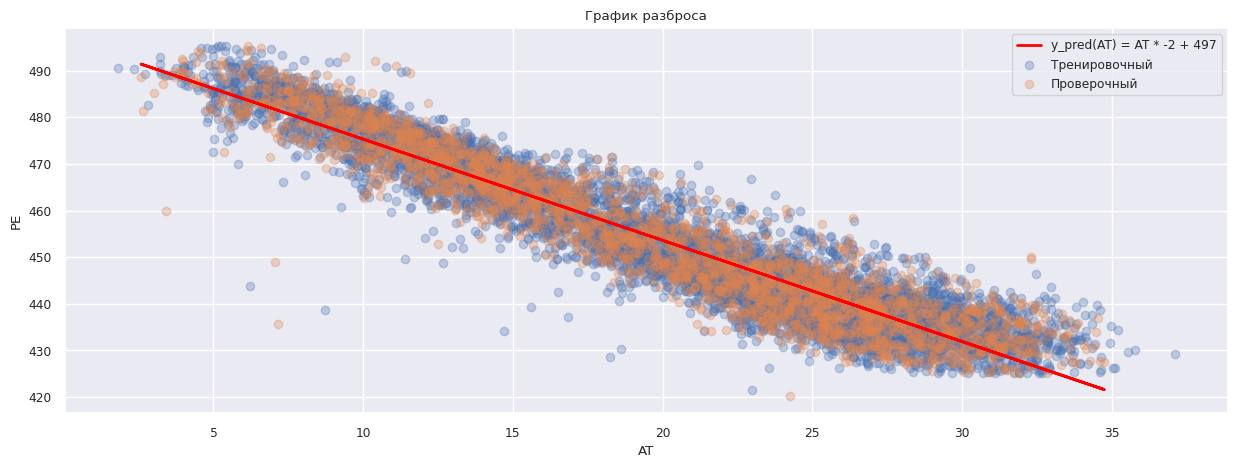

In [31]:
# Создать полотно для рисования с указаными размерами
plt.figure(figsize=(15,5))

# Нанести график рассеяния - plt.scatter
plt.scatter(x_train[['AT']],  y_train[['PE']], alpha=0.3, label='Тренировочный') # тренировочный
plt.scatter(x_test[['AT']],   y_test[['PE']],  alpha=0.3, label='Проверочный')   # проверочный

# Нанести график - линии через точки - plt.plot
label_str = "y_pred(AT) = AT * {:.0f} + {:.0f}".format(lin_model_AT.coef_[0][0], lin_model_AT.intercept_[0])

plt.plot(
    x_test[['AT']].values[:, 0], y_pred_PE_AT[:, 0],
    lw=2, color='red', label=label_str
)

plt.legend(loc="best")  # положение легенды
plt.xlabel('AT') # подпись осей
plt.ylabel(target[0])   # подпись осей
plt.title(u'График разброса'); # Заголовок

Т.к. модель является линейной имеются некоторые расхождения между реальными и вычисленными значениями - "ошибки". Для оценки точности построим гистограмму распределения ошибок

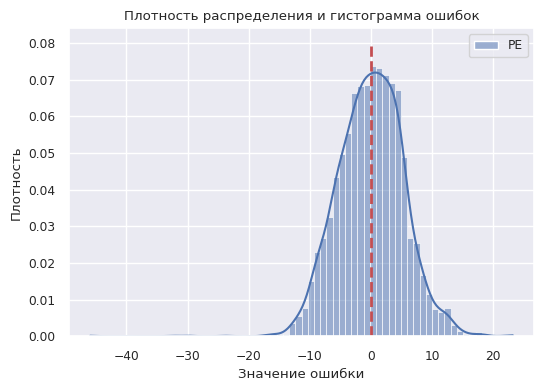

In [32]:
plt.figure(figsize=(6,4))

# Гистограмма и Плотность распределения - sns.distplot
# data = y_true - y_pred
#sns.distplot(y_test[['PE']]- y_pred_PE)
sns.histplot(y_test[['PE']] - y_pred_PE_AT, 
             color="red", 
             kde=True, # оценка плотности в виде кривой
             stat="density",# density: общая площадь равна 1
            )

# Осевая линия
plt.plot(
    [0, 0],
    [0, 0.08], '--', lw=2, c='r')

plt.ylabel(u'Плотность')
plt.xlabel(u'Значение ошибки')
plt.title(u'Плотность распределения и гистограмма ошибок');
plt.show()

Построим еще пару графиков для визуальной оценки качества модели

Text(0, 0.5, 'Абсолютная ошибка')

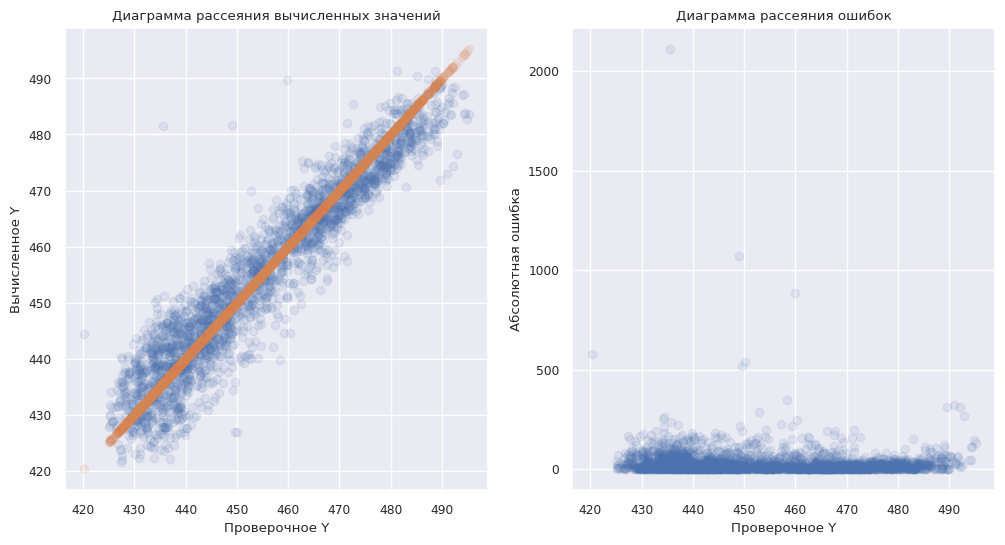

In [33]:
plt.figure(figsize=(12,6))

# создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс в сетке
plt.subplot(121)
plt.scatter(y_test[['PE']], y_pred_PE_AT,  alpha=0.1)
plt.scatter(y_test[['PE']], y_test[['PE']],  alpha=0.1)
plt.title('Диаграмма рассеяния вычисленных значений');
plt.xlabel('Проверочное Y')
plt.ylabel('Вычисленное Y')

# создать первое полотно 121: 1-строк, 2-столбцов, 2-индекс в сетке
plt.subplot(122)
plt.scatter(y_test[['PE']], (y_test[['PE']] - y_pred_PE_AT) ** 2,  alpha=0.1)

plt.title('Диаграмма рассеяния ошибок')
plt.xlabel('Проверочное Y')
plt.ylabel('Абсолютная ошибка')


С помощью функций __sklearn.metrics.*__ сравним реальные и вычисленные значениямя и получим важные оценки качества модели

In [34]:
print("Линейная одномерная регрессия. Признак 'AT'.")
print("y_pred_PE_AT(AT) = AT * {} + {}\n".format(
    lin_model_AT.coef_[0][0], lin_model_AT.intercept_[0])
)

r2_LinRegr_AT   = metrics.r2_score                   (y_test[['PE']], y_pred_PE_AT)
mae_LinRegr_AT  = metrics.mean_absolute_error        (y_test[['PE']], y_pred_PE_AT)
rmse_LinRegr_AT = np.sqrt(metrics.mean_squared_error (y_test[['PE']], y_pred_PE_AT))


print ("R2 - коэфф. детерминации:        {:>7,.3f}".format               ( r2_LinRegr_AT ))
print ("MAE - средняя абсолютная ошибка: {:>7,.3f}".format               ( mae_LinRegr_AT ))
print ("RMSE - кв. корень из среднеквадратичной ошибки: {:>7,.3f}".format( rmse_LinRegr_AT ))

Линейная одномерная регрессия. Признак 'AT'.
y_pred_PE_AT(AT) = AT * -2.170357323949751 + 497.0127608657101

R2 - коэфф. детерминации:          0.900
MAE - средняя абсолютная ошибка:   4.230
RMSE - кв. корень из среднеквадратичной ошибки:   5.387


## Многомерная модель от набора переменных: 'AT' и 'AP'

Для построение линейной регрессионной модели воспользуемся классом LinearRegression из модуля sklearn.linear_model, что и ранее при построение модели для одной переменной 'AT'.

После построения модели её необходимо обучить на тренировочных данных - в нашем случае это данные **x_train[['AT', 'AP']]** и **y_train[['PE']]**, т.н. тренировочные данные независимых переменных 'AT' и 'AP' и целевой переменной 'PE'.

После обучения модели необходимо вычислить значения целевой переменной на основе тестовых данных - **x_test[['AT', 'AP']]**. Эти данные в дальнейшем будут использоваться в сравнении с тестовыми данными **y_test[['PE']]** для оценки качества построенной модели.

In [35]:
lr_AT_AP = linear_model.LinearRegression()

# Вычисляем коэффициенты модели на тренировочном наборе, т.е. обучаем модель на этом наборе данных
lin_model_AT_AP = lr_AT_AP.fit(
    x_train[['AT', 'AP']],
    y_train[['PE']]
)

# Получаем вычисленные(predicted) значения выходной энергии электростанции на проверочном наборе
# по построенной и обученной модели
y_pred_PE_AT_AP  = lin_model_AT_AP.predict(x_test[['AT', 'AP']])

Как и для одномерной модели, в многомерной также имеются некоторые расхождения между реальными и вычисленными значениями. Для оценки точности обученной модели построим гистограмму распределения ошибок

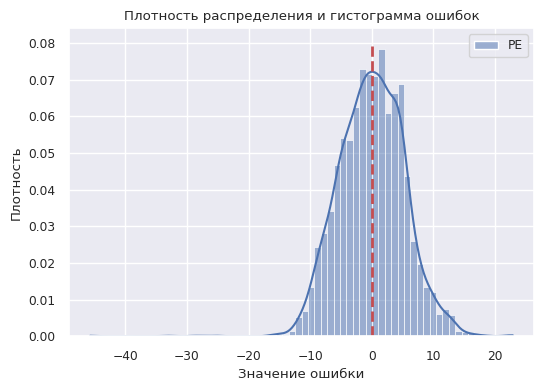

In [36]:
plt.figure(figsize=(6,4))

# Гистограмма и Плотность распределения - sns.distplot
# data = y_true - y_pred
#sns.distplot(y_test[['PE']]- y_pred_PE_AT_AP)
sns.histplot(
    y_test[['PE']] - y_pred_PE_AT_AP, 
    color="red", 
    kde=True, # оценка плотности в виде кривой
    stat="density",# density: общая площадь равна 1
)

# Осевая линия
plt.plot(
    [0, 0],
    [0, 0.08], '--', lw=2, c='r'
)

plt.ylabel(u'Плотность')
plt.xlabel(u'Значение ошибки')
plt.title(u'Плотность распределения и гистограмма ошибок');
plt.show()

Построим также диаграмму рассеяния вычисленных и тестовых значений целевой переменной, а также диаграмму рассеяния ошибки вычисленных значений относительно тестовых

Text(0, 0.5, 'Абсолютная ошибка')

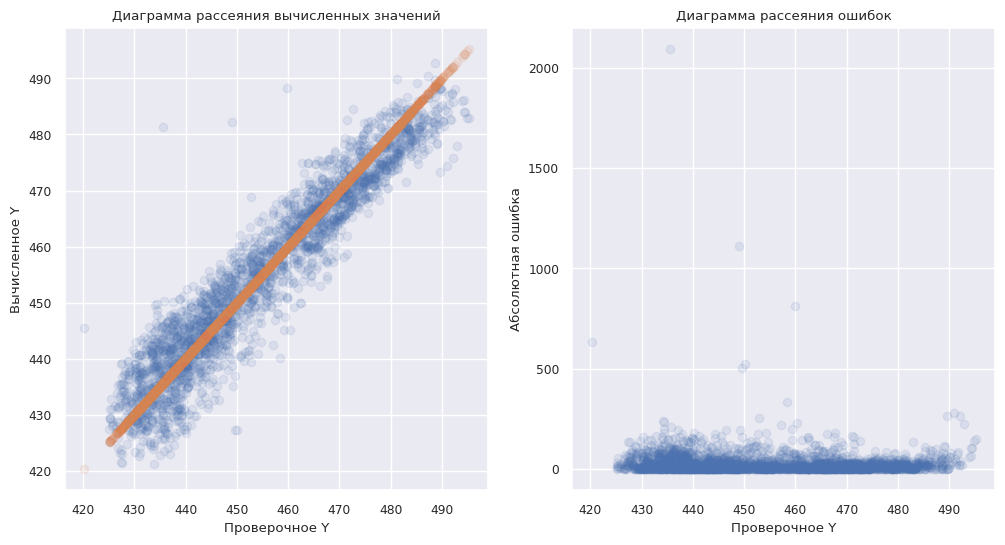

In [37]:
plt.figure(figsize=(12,6))

# создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс в сетке
plt.subplot(121)
plt.scatter(y_test[['PE']], y_pred_PE_AT_AP,  alpha=0.1)
plt.scatter(y_test[['PE']], y_test[['PE']],  alpha=0.1)
plt.title('Диаграмма рассеяния вычисленных значений');
plt.xlabel('Проверочное Y')
plt.ylabel('Вычисленное Y')

# создать первое полотно 121: 1-строк, 2-столбцов, 2-индекс в сетке
plt.subplot(122)
plt.scatter(y_test[['PE']], (y_test[['PE']] - y_pred_PE_AT_AP) ** 2,  alpha=0.1)

plt.title('Диаграмма рассеяния ошибок')
plt.xlabel('Проверочное Y')
plt.ylabel('Абсолютная ошибка')

Также произведём численный анализ полученных ошибок вычислений относительно тестовых данных - найдём коэффициент детерминации, среднюю абсолютную ошибку вычисления и квадратный корень из среднеквадратичной ошибки

In [38]:
print("Линейная многомерная регрессия. Признаки 'AT' и 'AP'.")
print("y_pred_PE_AT_AP(AT, AP) = AT * {} + AP * {} + {}\n".format(
    lin_model_AT_AP.coef_[:, 0][0],
    lin_model_AT_AP.coef_[:, 1][0],
    lin_model_AT_AP.intercept_[0]
))

r2_LinRegr_AT_AP   = metrics.r2_score                   (y_test[['PE']], y_pred_PE_AT_AP)
mae_LinRegr_AT_AP  = metrics.mean_absolute_error        (y_test[['PE']], y_pred_PE_AT_AP)
rmse_LinRegr_AT_AP = np.sqrt(metrics.mean_squared_error (y_test[['PE']], y_pred_PE_AT_AP))


print ("R2 - коэфф. детерминации:        {:>7,.3f}".format               ( r2_LinRegr_AT_AP ))
print ("MAE - средняя абсолютная ошибка: {:>7,.3f}".format               ( mae_LinRegr_AT_AP ))
print ("RMSE - кв. корень из среднеквадратичной ошибки: {:>7,.3f}".format( rmse_LinRegr_AT_AP ))

Линейная многомерная регрессия. Признаки 'AT' и 'AP'.
y_pred_PE_AT_AP(AT, AP) = AT * -2.112456203768854 + AP * 0.15012164635239897 + 343.7775349229568

R2 - коэфф. детерминации:          0.902
MAE - средняя абсолютная ошибка:   4.201
RMSE - кв. корень из среднеквадратичной ошибки:   5.324


## Многомерная модель от набора переменных: 'V' и 'RH'

По аналогии с двумя предыдущими пунктами построим линейную регрессионную модель, обучим её на имеющимся тренировочном наборе данных и затем вычислим значения целевой переменной 'PE'

In [39]:
lr_V_RH = linear_model.LinearRegression()

# Вычисляем коэффициенты модели на тренировочном наборе, т.е. обучаем модель на этом наборе данных
lin_model_V_RH = lr_V_RH.fit(
    x_train[['V', 'RH']],
    y_train[['PE']]
)

# Получаем вычисленные(predicted) значения выходной энергии электростанции на проверочном наборе
# по построенной и обученной модели
y_pred_PE_V_RH  = lin_model_V_RH.predict(x_test[['V', 'RH']])

Для оценки точности обученной модели построим гистограмму распределения ошибок

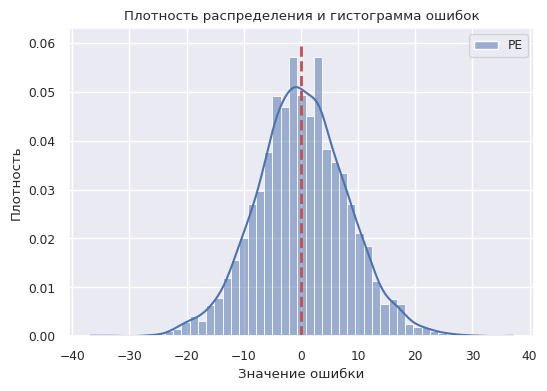

In [40]:
plt.figure(figsize=(6,4))

# Гистограмма и Плотность распределения - sns.distplot
# data = y_true - y_pred
#sns.distplot(y_test[['PE']]- y_pred_PE_V_RH)
sns.histplot(
    y_test[['PE']] - y_pred_PE_V_RH, 
    color="red", 
    kde=True, # оценка плотности в виде кривой
    stat="density",# density: общая площадь равна 1
)

# Осевая линия
plt.plot(
    [0, 0],
    [0, 0.06], '--', lw=2, c='r'
)

plt.ylabel(u'Плотность')
plt.xlabel(u'Значение ошибки')
plt.title(u'Плотность распределения и гистограмма ошибок');
plt.show()

Построим также диаграмму рассеяния вычисленных и тестовых значений целевой переменной, а также диаграмму рассеяния ошибки вычисленных значений относительно тестовых

Text(0, 0.5, 'Абсолютная ошибка')

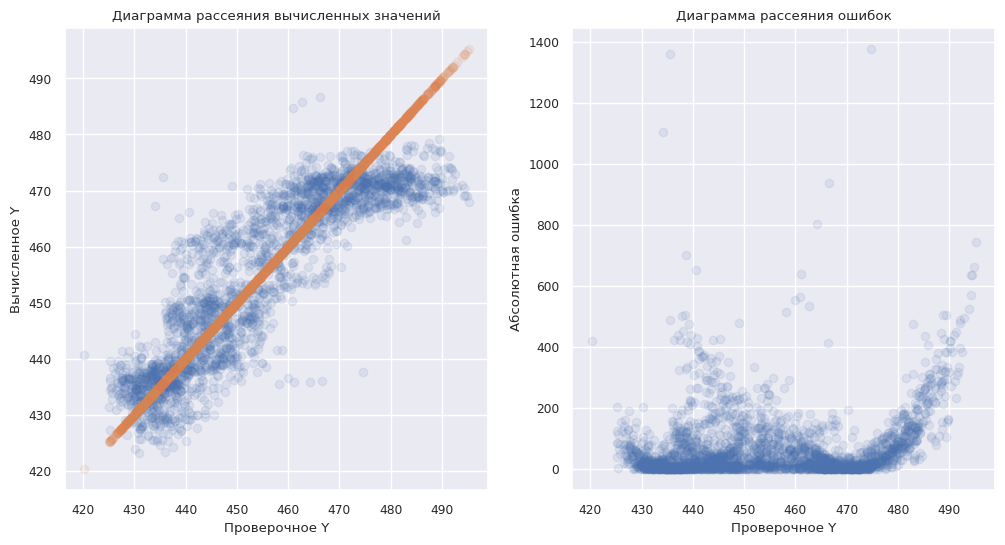

In [41]:
plt.figure(figsize=(12,6))

# создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс в сетке
plt.subplot(121)
plt.scatter(y_test[['PE']], y_pred_PE_V_RH,  alpha=0.1)
plt.scatter(y_test[['PE']], y_test[['PE']],  alpha=0.1)
plt.title('Диаграмма рассеяния вычисленных значений');
plt.xlabel('Проверочное Y')
plt.ylabel('Вычисленное Y')

# создать первое полотно 121: 1-строк, 2-столбцов, 2-индекс в сетке
plt.subplot(122)
plt.scatter(y_test[['PE']], (y_test[['PE']] - y_pred_PE_V_RH) ** 2,  alpha=0.1)

plt.title('Диаграмма рассеяния ошибок')
plt.xlabel('Проверочное Y')
plt.ylabel('Абсолютная ошибка')

Также произведём численный анализ полученных ошибок вычислений относительно тестовых данных - найдём коэффициент детерминации, среднюю абсолютную ошибку вычисления и квадратный корень из среднеквадратичной ошибки

In [42]:
print("Линейная многомерная регрессия. Признаки 'V' и 'RH'.")
print("y_pred_PE_V_RH(V, RH) = V * {} + RH * {} + {}\n".format(
    lin_model_V_RH.coef_[:, 0][0],
    lin_model_V_RH.coef_[:, 1][0],
    lin_model_V_RH.intercept_[0]
))

r2_LinRegr_V_RH   = metrics.r2_score                   (y_test[['PE']], y_pred_PE_V_RH)
mae_LinRegr_V_RH  = metrics.mean_absolute_error        (y_test[['PE']], y_pred_PE_V_RH)
rmse_LinRegr_V_RH = np.sqrt(metrics.mean_squared_error (y_test[['PE']], y_pred_PE_V_RH))


print ("R2 - коэфф. детерминации:        {:>7,.3f}".format               ( r2_LinRegr_V_RH ))
print ("MAE - средняя абсолютная ошибка: {:>7,.3f}".format               ( mae_LinRegr_V_RH ))
print ("RMSE - кв. корень из среднеквадратичной ошибки: {:>7,.3f}".format( rmse_LinRegr_V_RH ))

Линейная многомерная регрессия. Признаки 'V' и 'RH'.
y_pred_PE_V_RH(V, RH) = V * -1.1111866131295227 + RH * 0.15157965730580217 + 503.5214525745412

R2 - коэфф. детерминации:          0.778
MAE - средняя абсолютная ошибка:   6.283
RMSE - кв. корень из среднеквадратичной ошибки:   8.022


## Многомерная модель от набора переменных: 'AT', 'AP', 'V' и 'RH'

По аналогии с двумя предыдущими пунктами построим линейную регрессионную модель для всего набора имеющихся переменных в выборке, обучим эту модель на имеющимся тренировочном наборе данных и затем вычислим значения целевой переменной 'PE'

In [43]:
lr_AT_AP_V_RH = linear_model.LinearRegression()

# Вычисляем коэффициенты модели на тренировочном наборе, т.е. обучаем модель на этом наборе данных
lin_model_AT_AP_V_RH = lr_AT_AP_V_RH.fit(
    x_train[['AT', 'AP', 'V', 'RH']],
    y_train[['PE']]
)

# Получаем вычисленные(predicted) значения выходной энергии электростанции на проверочном наборе
# по построенной и обученной модели
y_pred_PE_AT_AP_V_RH  = lin_model_AT_AP_V_RH.predict(x_test[['AT', 'AP', 'V', 'RH']])

Для оценки точности обученной модели построим гистограмму распределения ошибок

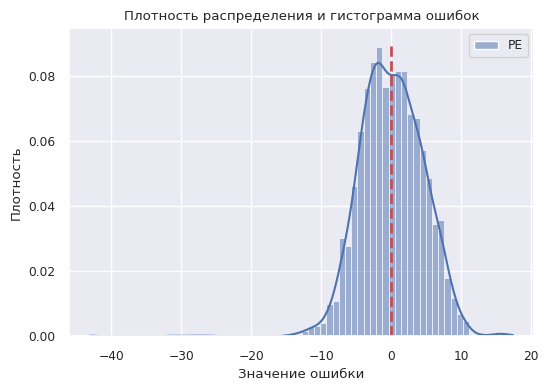

In [44]:
plt.figure(figsize=(6,4))

# Гистограмма и Плотность распределения - sns.distplot
# data = y_true - y_pred
#sns.distplot(y_test[['PE']]- y_pred_PE_AT_AP_V_RH)
sns.histplot(
    y_test[['PE']] - y_pred_PE_AT_AP_V_RH, 
    color="red", 
    kde=True, # оценка плотности в виде кривой
    stat="density",# density: общая площадь равна 1
)

# Осевая линия
plt.plot(
    [0, 0],
    [0, 0.09], '--', lw=2, c='r'
)

plt.ylabel(u'Плотность')
plt.xlabel(u'Значение ошибки')
plt.title(u'Плотность распределения и гистограмма ошибок');
plt.show()

Построим также диаграмму рассеяния вычисленных и тестовых значений целевой переменной, а также диаграмму рассеяния ошибки вычисленных значений относительно тестовых

Text(0, 0.5, 'Абсолютная ошибка')

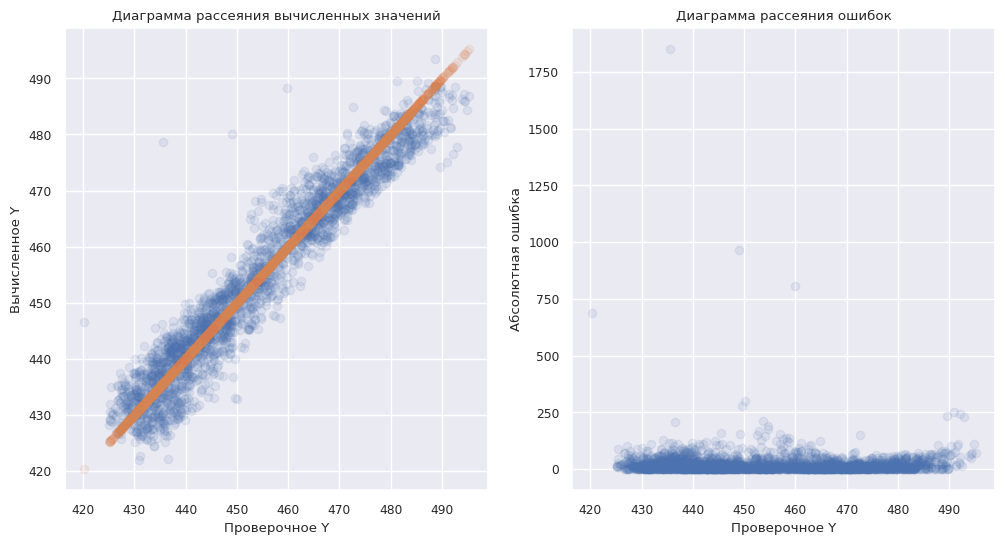

In [45]:
plt.figure(figsize=(12,6))

# создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс в сетке
plt.subplot(121)
plt.scatter(y_test[['PE']], y_pred_PE_AT_AP_V_RH,  alpha=0.1)
plt.scatter(y_test[['PE']], y_test[['PE']],  alpha=0.1)
plt.title('Диаграмма рассеяния вычисленных значений');
plt.xlabel('Проверочное Y')
plt.ylabel('Вычисленное Y')

# создать первое полотно 121: 1-строк, 2-столбцов, 2-индекс в сетке
plt.subplot(122)
plt.scatter(y_test[['PE']], (y_test[['PE']] - y_pred_PE_AT_AP_V_RH) ** 2,  alpha=0.1)

plt.title('Диаграмма рассеяния ошибок')
plt.xlabel('Проверочное Y')
plt.ylabel('Абсолютная ошибка')

Также произведём численный анализ полученных ошибок вычислений относительно тестовых данных - найдём коэффициент детерминации, среднюю абсолютную ошибку вычисления и квадратный корень из среднеквадратичной ошибки

In [46]:
print("Линейная многомерная регрессия. Признаки 'V' и 'RH'.")
print("y_pred_PE_V_RH(AT, AP, V, RH) = AT * {} + AP * {} + {} * V + {} * RH + {}\n".format(
    lin_model_AT_AP_V_RH.coef_[:, 0][0],
    lin_model_AT_AP_V_RH.coef_[:, 1][0],
    lin_model_AT_AP_V_RH.coef_[:, 2][0],
    lin_model_AT_AP_V_RH.coef_[:, 3][0],
    lin_model_AT_AP_V_RH.intercept_[0]
))

r2_LinRegr_AT_AP_V_RH   = metrics.r2_score                   (y_test[['PE']], y_pred_PE_AT_AP_V_RH)
mae_LinRegr_AT_AP_V_RH  = metrics.mean_absolute_error        (y_test[['PE']], y_pred_PE_AT_AP_V_RH)
rmse_LinRegr_AT_AP_V_RH = np.sqrt(metrics.mean_squared_error (y_test[['PE']], y_pred_PE_AT_AP_V_RH))


print ("R2 - коэфф. детерминации:        {:>7,.3f}".format               ( r2_LinRegr_AT_AP_V_RH ))
print ("MAE - средняя абсолютная ошибка: {:>7,.3f}".format               ( mae_LinRegr_AT_AP_V_RH ))
print ("RMSE - кв. корень из среднеквадратичной ошибки: {:>7,.3f}".format( rmse_LinRegr_AT_AP_V_RH ))

Линейная многомерная регрессия. Признаки 'V' и 'RH'.
y_pred_PE_V_RH(AT, AP, V, RH) = AT * -1.9903996140224918 + AP * 0.06288857981830831 + -0.23085743621466098 * V + -0.16386963200040283 * RH + 454.29614690737776

R2 - коэфф. детерминации:          0.929
MAE - средняя абсолютная ошибка:   3.589
RMSE - кв. корень из среднеквадратичной ошибки:   4.540


# Итоги. Сравнение полученных моделей

Размеры таблицы
- исходная таблица = Строк x Столбцов
- после искл пропущенных значений = Строк x Столбцов
- после искл выбросов = Строк x Столбцов


In [47]:
import pandas as pd

ddf = pd.DataFrame (
    {
        "Признак": ["AT", "AT, AP", "V, RH", "AT, AP, V, RH"],
        "K":       [lin_model_AT.coef_[0][0], lin_model_AT_AP.coef_[:, :][0], lin_model_V_RH.coef_[:, :][0], lin_model_AT_AP_V_RH.coef_[:, :][0]],
        "B":       [lin_model_AT.intercept_[0], lin_model_AT_AP.intercept_[0], lin_model_V_RH.intercept_[0], lin_model_AT_AP_V_RH.intercept_[0]],
        "MAE":     [mae_LinRegr_AT, mae_LinRegr_AT_AP, mae_LinRegr_V_RH, mae_LinRegr_AT_AP_V_RH],
        "RMSE":    [rmse_LinRegr_AT, rmse_LinRegr_AT_AP, rmse_LinRegr_V_RH, rmse_LinRegr_AT_AP_V_RH],
        "R2":      [r2_LinRegr_AT, r2_LinRegr_AT_AP, r2_LinRegr_V_RH, r2_LinRegr_AT_AP_V_RH]
    }
 )
ddf

Признак                                                  K  \
0             AT                                          -2.170357   
1         AT, AP          [-2.112456203768854, 0.15012164635239897]   
2          V, RH         [-1.1111866131295227, 0.15157965730580217]   
3  AT, AP, V, RH  [-1.9903996140224918, 0.06288857981830831, -0....   

            B       MAE      RMSE        R2  
0  497.012761  4.229557  5.386930  0.899782  
1  343.777535  4.200800  5.324469  0.902093  
2  503.521453  6.282564  8.021703  0.777773  
3  454.296147  3.589011  4.539780  0.928824

Уравнения линейных регрессионных моделей 

In [48]:
print("y_pred_PE_AT(AT) = AT * {} + {}\n".format(
    lin_model_AT.coef_[0][0], lin_model_AT.intercept_[0])
)
print("y_pred_PE_AT_AP(AT, AP) = AT * {} + AP * {} + {}\n".format(
    lin_model_AT_AP.coef_[:, 0][0],
    lin_model_AT_AP.coef_[:, 1][0],
    lin_model_AT_AP.intercept_[0]
))
print("y_pred_PE_V_RH(V, RH) = V * {} + RH * {} + {}\n".format(
    lin_model_V_RH.coef_[:, 0][0],
    lin_model_V_RH.coef_[:, 1][0],
    lin_model_V_RH.intercept_[0]
))
print("y_pred_PE_V_RH(AT, AP, V, RH) = AT * {} + AP * {} + {} * V + {} * RH + {}\n".format(
    lin_model_AT_AP_V_RH.coef_[:, 0][0],
    lin_model_AT_AP_V_RH.coef_[:, 1][0],
    lin_model_AT_AP_V_RH.coef_[:, 2][0],
    lin_model_AT_AP_V_RH.coef_[:, 3][0],
    lin_model_AT_AP_V_RH.intercept_[0]
))

y_pred_PE_AT(AT) = AT * -2.170357323949751 + 497.0127608657101

y_pred_PE_AT_AP(AT, AP) = AT * -2.112456203768854 + AP * 0.15012164635239897 + 343.7775349229568

y_pred_PE_V_RH(V, RH) = V * -1.1111866131295227 + RH * 0.15157965730580217 + 503.5214525745412

y_pred_PE_V_RH(AT, AP, V, RH) = AT * -1.9903996140224918 + AP * 0.06288857981830831 + -0.23085743621466098 * V + -0.16386963200040283 * RH + 454.29614690737776



# Выводы по работе

В ходе выполнения данной лабораторной работы были обработаны исходные данные, а именно исключены строки с какими-либо отсутствующими значениями, выбрана целевая переменная - 'PE', т.н. выходная мощность электростанции, и независимые переменные 'AT', 'AP', 'RH' и 'V', т.н. температура, давление, относительная влажность среды и объём выхлопных газов. Для исходной выборки были обработаны выбросы: из 9468 записей были удалены 92, которые и являются значениями выбросов, т.н. сильно отклоняются относительно средних значений. По полученным данным были выделены наборы тренировочных и тестовых данных. Тестовые данные составили 30% объёма выборки.

Для исходной выборки был произведён корреляционный анализ, т.н. выделены имеющиеся сильные корреляционные связи, коэффициент корреляции которых больше 0.8 по модулю. Наиболее существенными связями являются те, в которых учавствует целевая переменная 'PE', поскольку 'PE' является одним из главных показателей работы электростанции. Таких связей оказалось две: между 'PE' и 'AT' с коэффициентом корреляции -0.95, и между 'PE' и 'V' с коэффициентом корреляции -0.87.

Для обработанной выборки, т.н. с исключёнными выбросами и выделенными тренировочными и тестовыми данными, были построены 4 линейные регрессионные модели с целевой переменной 'PE':
   1. С единственной переменной 'AT';
   2. С набором переменных 'AT' и 'AP';
   3. С набором переменных 'V' и 'RH';
   4. С набором переменных 'AT', 'AP', 'V' и 'RH';

Для каждой модели была произведена оценка её точности: построены гистограммы распределения ошибок, графики рассеяния вычисленных значений и ошибок, а также вычислены показатели точности:
   * Коэффициент детерминации (R2);
   * Средняя абсолютная ошибка (MAE);
   * Квадратный корень из среднеквадратичной ошибки (RMSE);

Сводная таблица полученных значений приведена в предыдущем пункте работы.

Коэффициент детерминации имеет существенное значение даже для модели с одной переменной 'AT', он составил значение, примерно равное 0.9, что говорит о высокой точности построенной модели. Кроме того, можно заметить, при добавлении в модель другой переменной 'AP', этот коэффициент не сильно изменился - увеличился примерно на 0.002, что говорит о том, что существенное влияние на выходную мощность электростанции оказывает температура окружающей среды, а не её давление.

При другом наборе переменных: 'V' и 'RH', можно заметить уменьшение данного коэффициента относительно первой модели до значения, примерно равного 0.78, при этом исходя из вычисленных коэффициентов Ki для 'V' и 'RH', можно заметить, что больший по модулю коэффициент при переменной 'V', а значит в рамках данной модели объём выхлопных газов оказывает большее влияние на выходную мощность электростанции, чем относительная влажность.

При этом для последней модели с полным набором независимых переменных, в которых находятся обе переменные 'AT' и 'V' можно снова заметить относительно небольшое изменение коэффициента детерминации - он увеличился примерно на 0.2 относительно модели с одной переменной 'AT'. Это связано с тем, что переменные 'AT' и 'V' имеют достаточно сильную корреляционную связь между друг другом с коэффициентом корреляции 0.84, **поэтому, в действительности, на целевую переменную оказывает влияние не объём выхлопных газов, а температура окружающей среды, что также подтверждает уравнение для модели с четырьмя переменными, где коэффициент при переменной 'AT' наибольший по модулю**.

**Влияние температуры окружающей среды на выходную мощность отрицательно, поэтому для увеличения выходной мощности электростанции следует стараться уменьшить значение температуры.**

**Средняя абсолютная ошибка (MAE) и квадратный корень из среднеквадратичной ошибки (RMSE) для выходной мощности электростанции имеют относительно небольшое значение - до 2%**, при этом наименьшая ошибка наблюдается в четвёртой модели, а наибольная - в третьей. Объясняется это тем, что в четвёртой модели учавствуют все независимые переменные, и поэтому она наиболее близка к реальной модели, а в третьей модели не учавствует переменная 'AT', которая, как выяснилось ранее, оказывает наиболее существенное влияние на целевую переменную.